# Initializations

## imports

In [21]:
from torchvision.datasets import MNIST
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

import torch
import torchvision

import seaborn as sns
import numpy as np

## configs

In [2]:
batch_size_train = 128
batch_size_test = 100
random_seed = 12453211


torch.manual_seed(random_seed)
np.random.seed(random_seed)

# Data Preparation

## Loading torch dataset

In [4]:

train_set = torchvision.datasets.MNIST(
    '.',
    train=True,
    download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ])
)

train_set, val_set = torch.utils.data.random_split(train_set, [50000, 10000])

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size_train,
    shuffle=True
)

valid_loader = torch.utils.data.DataLoader(
    val_set,
    batch_size=batch_size_train,
    shuffle=True,
)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('.', train=False, download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
        (0.1307,), (0.3081,))
    ])),
    batch_size=batch_size_test,
    shuffle=False
)

## loading numpy dataset

In [12]:
def data_loader_to_numpy(data_loader):
    result_x = []
    result_y = []
    for x, y in data_loader:
        result_x.append(x.numpy())
        result_y.append(y.numpy())
        
    return np.concatenate(result_x, axis=0), np.concatenate(result_y, axis=0)
    
train_x, train_y = data_loader_to_numpy(train_loader)
test_x, test_y = data_loader_to_numpy(test_loader)
valid_x, valid_y = data_loader_to_numpy(valid_loader)

print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)

(50000, 1, 28, 28) (10000, 1, 28, 28) (50000,) (10000,)


## distribution of classes

<AxesSubplot:ylabel='Count'>

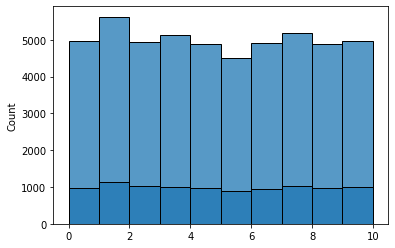

In [25]:
sns.histplot(train_y, bins=[i for i in range(11)])
sns.histplot(test_y, bins=[i for i in range(11)])

## Creating noisy datasets

# Models

## validation functions

### draw confusion matrix

In [48]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

def conf_mat(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,8))
    sns.heatmap(cm, annot=True)



In [57]:
from sklearn.metrics import classification_report

def clf_metrics(y_true, y_pred, n_class=10):
    class_names = [str(i) for i in range(n_class)]
    print(classification_report(y_true, y_pred))
    


## SVM

### preprocessing data

In [16]:
def preprocess(x, y):
    x, y = x.squeeze(), y
    return x.reshape((x.shape[0], -1)), y

train_x, train_y = preprocess(train_x, train_y)
test_x, test_y = preprocess(test_x, test_y)
valid_x, valid_y = preprocess(valid_x, valid_y)

train_x.shape

(50000, 784)

### model definition

In [18]:
svm = SVC(
    kernel='linear',
    decision_function_shape='ovr',
    random_state=random_seed,
    verbose=True,
) 

svm.fit(train_x, train_y)
y_pred = svm.predict(test_x)

[LibSVM]*
optimization finished, #iter = 566
obj = -0.214330, rho = 0.372860
nSV = 67, nBSV = 0
......................*...............*
optimization finished, #iter = 37300
obj = -9.892223, rho = 4.243643
nSV = 301, nBSV = 0
.......*......*
optimization finished, #iter = 13131
obj = -2.908381, rho = 2.822154
nSV = 219, nBSV = 0
..*..*
optimization finished, #iter = 4184
obj = -0.994940, rho = 1.074075
nSV = 165, nBSV = 0
.....................................................*...................................*
optimization finished, #iter = 88279
obj = -31.133474, rho = 10.758489
nSV = 326, nBSV = 1
.........*.....*
optimization finished, #iter = 14960
obj = -5.314474, rho = 0.553526
nSV = 233, nBSV = 0
..*.*
optimization finished, #iter = 3343
obj = -0.842590, rho = 1.093256
nSV = 148, nBSV = 0
.........................*....................*
optimization finished, #iter = 45102
obj = -13.929025, rho = 2.170876
nSV = 286, nBSV = 0
.....*...*
optimization finished, #iter = 8588
obj = -2

...................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................*....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

..............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................*.........................................................................................................................................................................................................................................................................................................................................................................................................................

In [43]:
svm.coef_.shape

(45, 784)

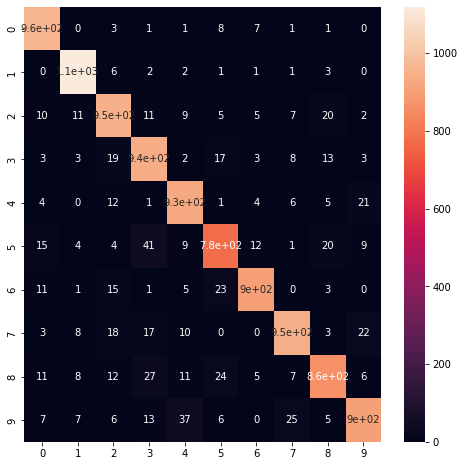

In [37]:
conf_mat(test_y, y_pred)

### model report

In [58]:
clf_metrics(test_y, y_pred)

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       980
           1       0.96      0.99      0.97      1135
           2       0.91      0.92      0.92      1032
           3       0.89      0.93      0.91      1010
           4       0.92      0.95      0.93       982
           5       0.90      0.87      0.89       892
           6       0.96      0.94      0.95       958
           7       0.94      0.92      0.93      1028
           8       0.92      0.89      0.90       974
           9       0.93      0.89      0.91      1009

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



## Logistic Regression

### preprocessing data

In [ ]:
#TODO: flattening the entries    

### defining model

### training

In [ ]:
#TODO: search on a few hyperparameters and tune on validation set

### results

# Validation